In [1]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost                 import XGBClassifier
from sklearn.metrics         import accuracy_score
from hyperopt                import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn         import metrics
import pickle

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
# %load load_list_var.py
def load_vars(type):

    if type == "numerical":

        vars = []
        with open("Data/num_var.txt", "r") as f:
            for line in f:
                vars.append(str(line.strip()))

    elif type == "categorical":

        vars = []
        with open("Data/cat_var.txt", "r") as f:
            for line in f:
                vars.append(str(line.strip()))

    else:

        print("Not properly loaded var, type is {}".format(type))

    return vars


In [5]:
datasets = ['Output_preprocessing/Training_set_woe_cat.csv.gz',
            'Output_xgboost_unrestricted/Training_unrestricted_woe_6.csv.gz',
            'Output_xgboost_binning/Training_with_woe_on_numerical_6.csv.gz',
            'Output_xgboost_ex_ante_binning/Training_XGB_ex_woe_6.csv.gz']

names    = ['original',
            'unrestricted_6',
            'best_6',
            'ex_ante_6']

numobs   = int(5e4)

variables = [*load_vars('numerical'), *load_vars('categorical')]
variables.remove('CODE_GENDER')
variables.remove('EXT_SOURCE_1')
variables.remove('EXT_SOURCE_2')
variables.remove('EXT_SOURCE_3')

params   = {
         'min_child_weight': [1, 10],
         'max_depth': [4,8,12],
         'eta': [0.1, 0.3, 0.7],
         'subsample': [0.4,0.7,1],
         'eval_metric': ['auc'],
         'use_label_encoder':[False],
         'silent':[1],
         'nthread': [10],
         'n_estimators': [100]
         }


In [6]:
def monotony(name, variables):
    monoton     = np.zeros(len(variables))
    categorical = load_vars('categorical')
    
    if name == 'ex_ante_6':
        '''
        desc = pd.read_csv('Data/HomeCredit_columns_description.csv.gz', compression='gzip')
        
        for idx, var in enumerate(variables):
            if var not in categorical:
                monoton[idx] = desc[desc.Row == var]['Ex_ante'].values[0]
        '''
        monoton = np.ones(len(variables))
    
    if name == 'best_6':
        '''
        f = open('Output_CV/best_monotonicity.txt','r')
        restriction = eval(f.read())
        f.close()
        
        for idx, var in enumerate(variables):
            try:
                monoton[idx] = restriction[var]
            except KeyError:
                pass
        '''
        monoton = np.ones(len(variables))
        
    monoton = [int(i) for i in monoton]
    return str(tuple(monoton))

In [6]:
monotony('best', variables)

'(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)'

In [7]:
for (dataset, name) in zip(datasets, names):
    
    # load data for the CV fit
    
    training_data = pd.read_csv(dataset, compression='gzip')

    training_data_sub = training_data.iloc[:numobs,:]

    y = training_data_sub['TARGET'].copy()
    X = training_data_sub[variables].copy()
    
    # Deleting useless variables to save memory

    del training_data, training_data_sub
    
    # model 
    
    monotone_constrain = monotony(name, variables)
    
    xgb_classifier = XGBClassifier(objective='binary:logistic', monotone_constraints = monotone_constrain)
    
    # look for the hyperparameters

    searcher_cv = GridSearchCV(estimator = xgb_classifier, param_grid = params, cv=5)

    start_time = timer(None)
    searcher_cv.fit(X, y)
    timer(start_time)
    
    # Save the best model
    
    pickle.dump(searcher_cv.best_estimator_, open('Output_CV/{}.sav'.format(name), 'wb'))

[12:37:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:37:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:37:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [8]:

test_names = ['Output_preprocessing/Testing_set_woe_cat.csv.gz',
              'Output_xgboost_unrestricted/Testing_unrestricted_woe_6.csv.gz',
              'Output_xgboost_binning/Testing_with_woe_on_numerical_6.csv.gz',
              'Output_xgboost_ex_ante_binning/Testing_XGB_ex_woe_6.csv.gz']

for (name, test_name) in zip(names, test_names):
    filename = 'Output_CV/{}.sav'.format(name)
    data = pd.read_csv(test_name, compression='gzip')
    
    loaded_model = pickle.load(open(filename, 'rb'))
    print('model {} AUC is: '.format(name), roc_auc_score(data['TARGET'], loaded_model.predict_proba(data[variables])[:,1]))


model original AUC is:  0.7150441929332559
model unrestricted_6 AUC is:  0.7081441557883144
model best_6 AUC is:  0.7054981851986867
model ex_ante_6 AUC is:  0.7035723872334685


In [12]:
filename = 'Output_CV/best_6.sav'
loaded_model = pickle.load(open(filename, 'rb'))

data = pd.read_csv(test_name, compression='gzip')

In [14]:
loaded_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.100000001,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': '(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

model original AUC is:  0.5946136269397362
model unrestricted_6 AUC is:  0.7694078566502731
model best_6 AUC is:  0.7259224275445215
model ex_ante_6 AUC is:  0.7518706893041627


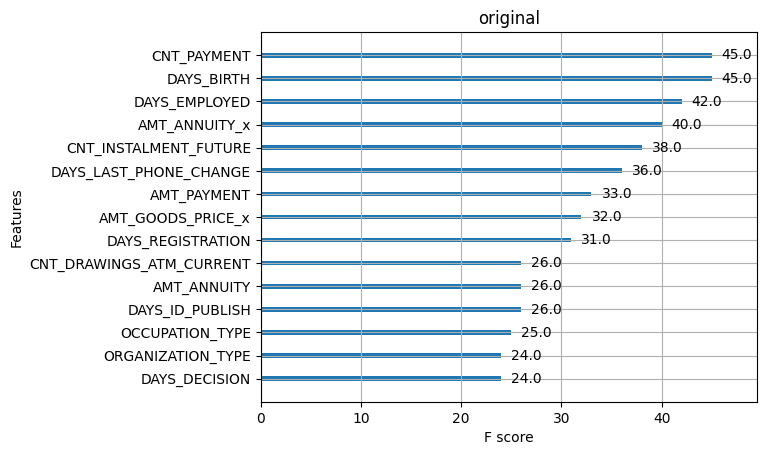

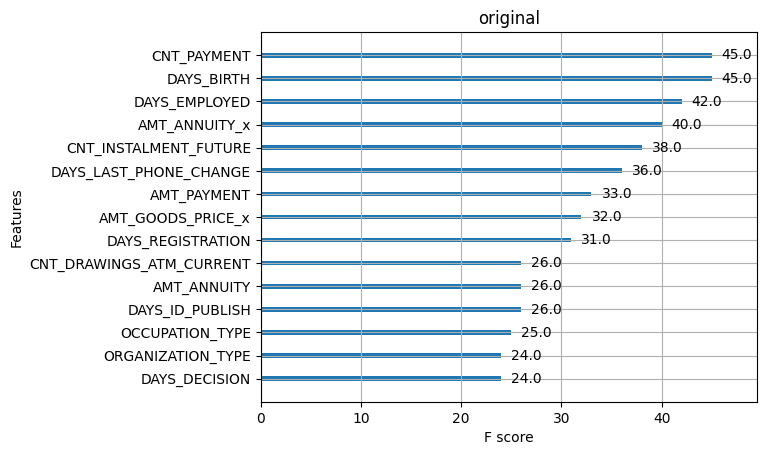

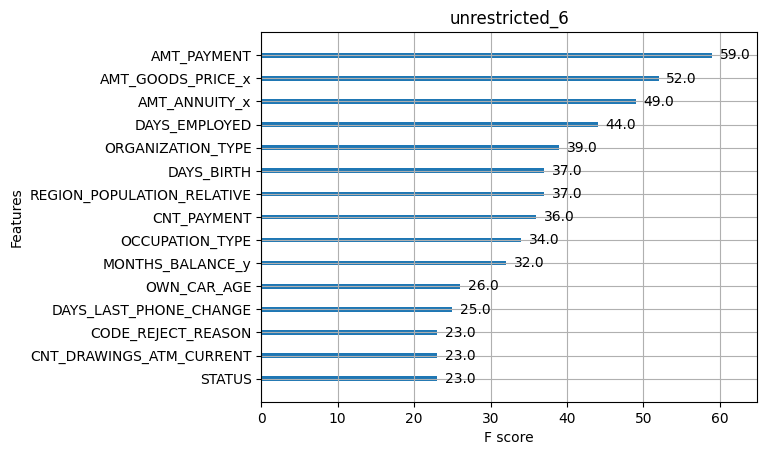

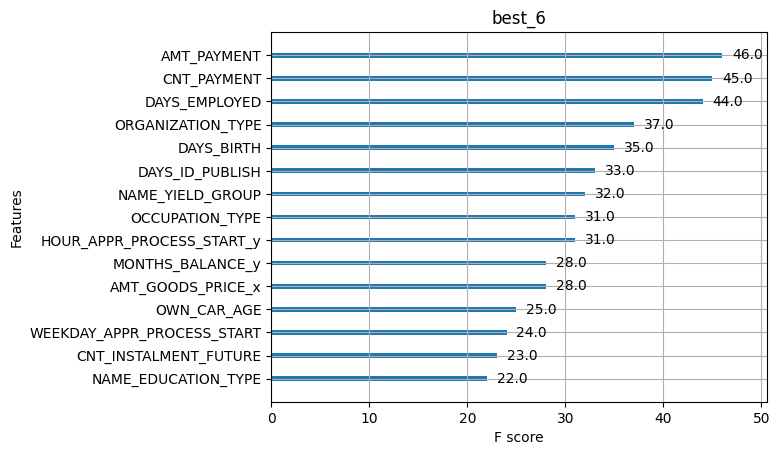

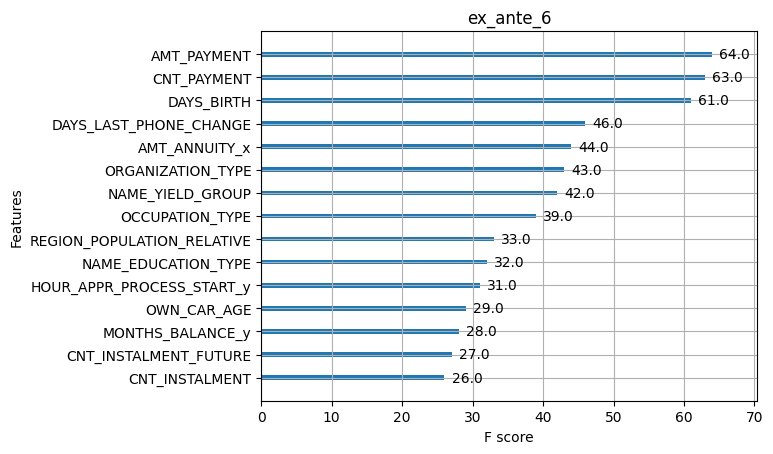

In [10]:
for name in names:
    filename = 'Output_CV/{}.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    xgb.plot_importance(loaded_model, max_num_features=15)
    plt.title('{}'.format(name))
    print('model {} AUC is: '.format(name), roc_auc_score(y, loaded_model.predict_proba(X)[:,1]))
plt.show()

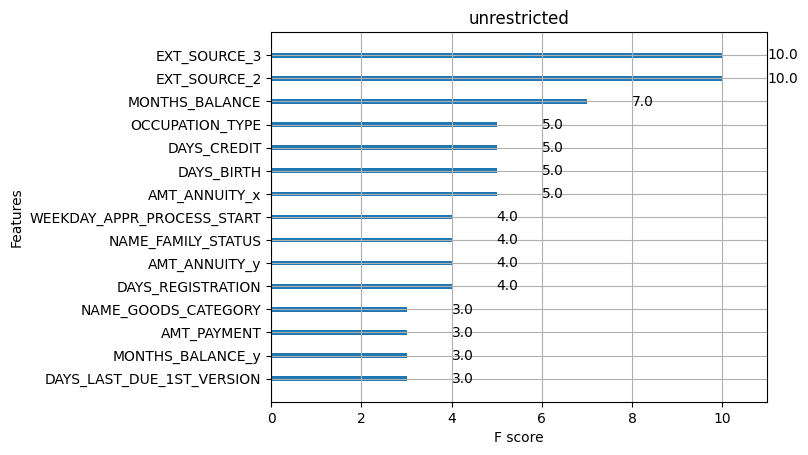

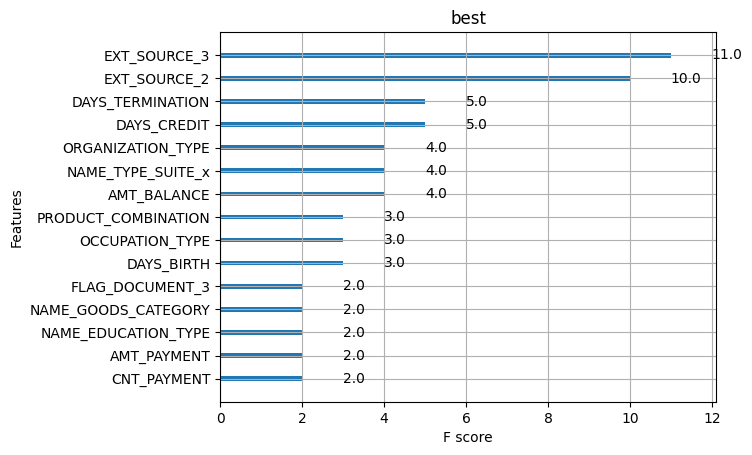

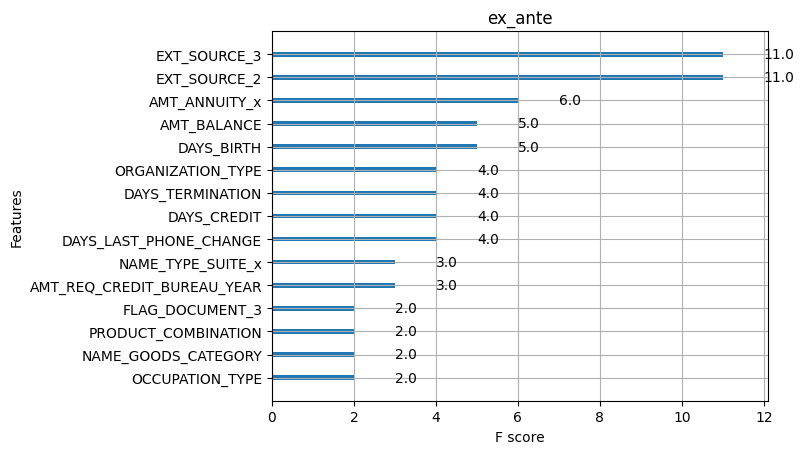

In [20]:
for name in names:
    filename = 'Output_CV/{}.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    xgb.plot_importance(loaded_model, max_num_features=15)
    plt.title('{}'.format(name))
plt.show()

model original AUC is:  0.617667428079262
0.4
model unrestricted_6 AUC is:  0.7621582805985734
1
model best_6 AUC is:  0.7471505908628354
0.7
model ex_ante_6 AUC is:  0.7585363192004972
0.4


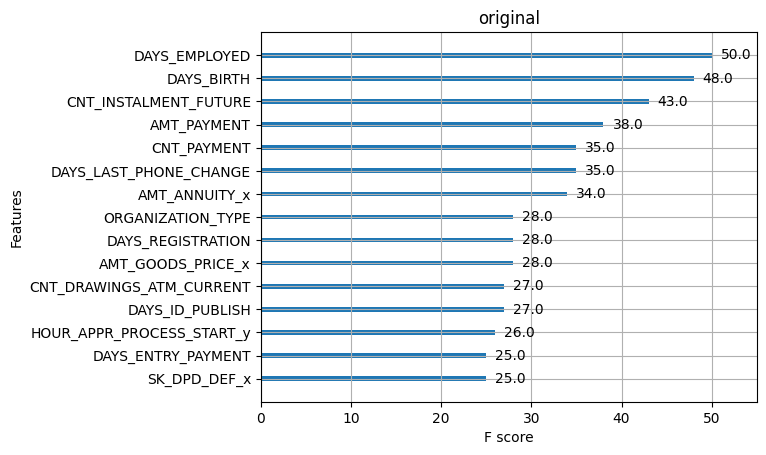

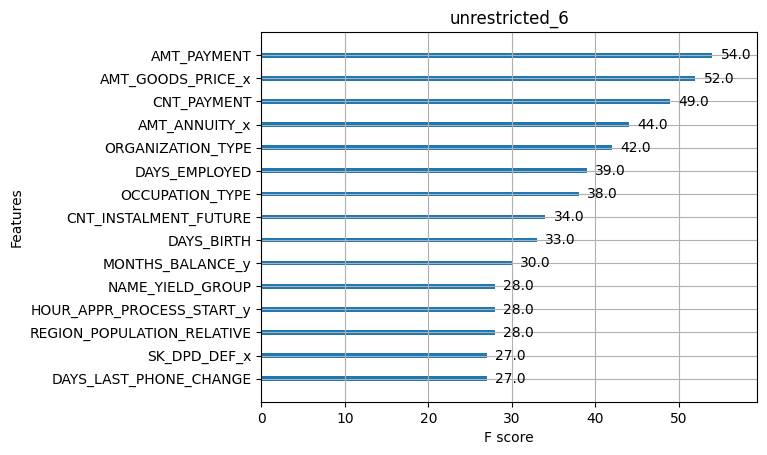

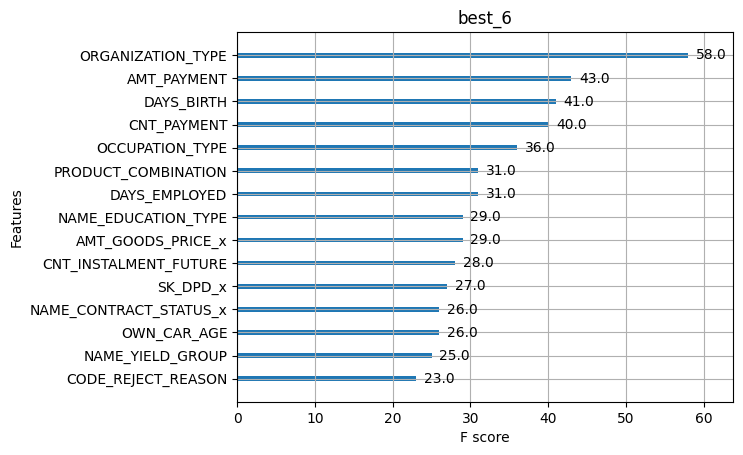

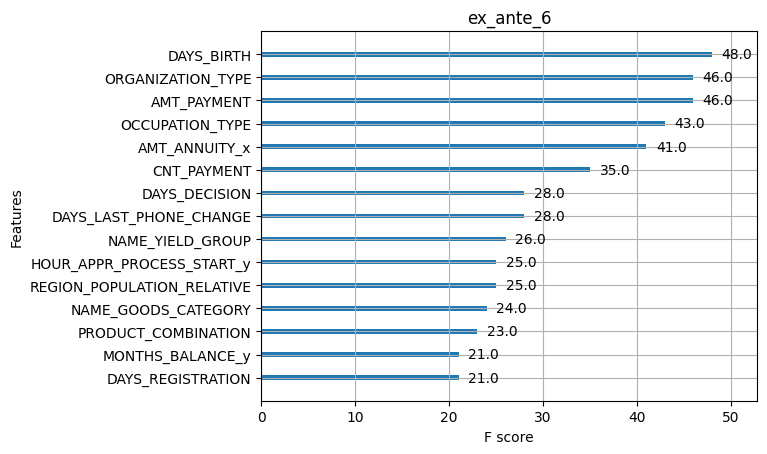

In [22]:
for name in names:
    filename = 'Output_CV/{}.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    xgb.plot_importance(loaded_model, max_num_features=15)
    plt.title('{}'.format(name))
    print('model {} AUC is: '.format(name), roc_auc_score(y, loaded_model.predict_proba(X)[:,1]))
    print(loaded_model.get_params()['subsample'])
plt.show()